In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)
ratings = Y_train[:, 2:]
mean_rating = np.mean(ratings)


In [3]:
# Solution set for CS 155 Set 6, 2016/2017
# Authors: Fabian Boemer, Sid Murching, Suraj Nair

import numpy as np

def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, b1, b2, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - ((np.dot(U[i-1], V[:,j-1])) + mean_rating + b1[i-1] + b2[j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def get_single_err(U, V, i, j, Yij, b1, b2, reg=0.0):
    prediction = mean_rating + b1[i-1] + b2[j-1] + (np.dot(U[i-1], V[:,j-1]))
    error = Yij - prediction
    return error

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    bias_u = np.zeros(M)
    bias_v = np.zeros(N)
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, bias_u, bias_v, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            error = get_single_err(U, V, i, j, Yij, bias_u, bias_v, reg)
            bias_u[i-1] += eta * (error - reg * bias_u[i-1])
            bias_v[j-1] += eta * (error - reg * bias_v[j-1])
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, bias_u, bias_v, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early 
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y, bias_u, bias_v, reg), bias_u, bias_v)

In [4]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20 
regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
eta = 0.03 # learning rate
E_in = []
E_out = []

Factorizing with  943  users,  1682  movies.


In [5]:
for reg in regs:

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, e_in, bias_u, bias_v = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(e_in)
    eout = get_err(U, V, Y_test, bias_u, bias_v)
    E_out.append(eout)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.0001
Epoch 1, E_in (regularized MSE): 0.681044538554
Epoch 2, E_in (regularized MSE): 0.473133755332
Epoch 3, E_in (regularized MSE): 0.398142314994
Epoch 4, E_in (regularized MSE): 0.357425992991
Epoch 5, E_in (regularized MSE): 0.335046461193
Epoch 6, E_in (regularized MSE): 0.312369498923
Epoch 7, E_in (regularized MSE): 0.301971128048
Epoch 8, E_in (regularized MSE): 0.292687259292
Epoch 9, E_in (regularized MSE): 0.28604247541
Epoch 10, E_in (regularized MSE): 0.280705425209
Epoch 11, E_in (regularized MSE): 0.273196695759
Epoch 12, E_in (regularized MSE): 0.271830982784
Epoch 13, E_in (regularized MSE): 0.265811011973
Epoch 14, E_in (regularized MSE): 0.266230049053
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.001
Epoch 1, E_in (regularized MSE): 0.684236502636
Epoch 2, E_in (regularized MSE): 0.469031674181
Epoch 3, E_in (regularized MSE): 0.394761408657
Epoch 4, E_in (regularized MSE): 0.36

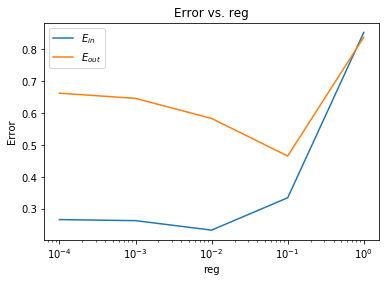

In [6]:
plt.plot(regs, E_in, label='$E_{in}$')
plt.plot(regs, E_out, label='$E_{out}$')
plt.xscale('log')
plt.title('Error vs. reg')
plt.xlabel('reg')
plt.ylabel('Error')
plt.legend()
plt.show()

In [8]:
regs = [0.06, 0.08, 0.1, 0.12, 0.14]
E_in2 = []
E_out2 = []
for reg in regs:

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, e_in, bias_u, bias_v = train_model(M, N, K, eta, reg, Y_train)
    E_in2.append(e_in)
    eout = get_err(U, V, Y_test, bias_u, bias_v)
    E_out2.append(eout)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.06
Epoch 1, E_in (regularized MSE): 0.644817498631
Epoch 2, E_in (regularized MSE): 0.474062680581
Epoch 3, E_in (regularized MSE): 0.422321037169
Epoch 4, E_in (regularized MSE): 0.387543288757
Epoch 5, E_in (regularized MSE): 0.364807745538
Epoch 6, E_in (regularized MSE): 0.346975245304
Epoch 7, E_in (regularized MSE): 0.337438702365
Epoch 8, E_in (regularized MSE): 0.327590162105
Epoch 9, E_in (regularized MSE): 0.309778538723
Epoch 10, E_in (regularized MSE): 0.308288017873
Epoch 11, E_in (regularized MSE): 0.296032505587
Epoch 12, E_in (regularized MSE): 0.286990272623
Epoch 13, E_in (regularized MSE): 0.284059988341
Epoch 14, E_in (regularized MSE): 0.277846045543
Epoch 15, E_in (regularized MSE): 0.277285833299
Epoch 16, E_in (regularized MSE): 0.271387829692
Epoch 17, E_in (regularized MSE): 0.270148264326
Epoch 18, E_in (regularized MSE): 0.26616185259
Epoch 19, E_in (regularized MSE): 0.26108357859
Epoch 20, 

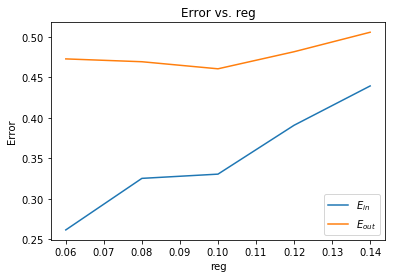

In [9]:
plt.plot(regs, E_in2, label='$E_{in}$')
plt.plot(regs, E_out2, label='$E_{out}$')
plt.title('Error vs. reg')
plt.xlabel('reg')
plt.ylabel('Error')
plt.legend()
plt.show()

In [10]:
eps = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
reg = 0.1
E_in3 = []
E_out3 = []
for ep in eps:

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V, e_in, bias_u, bias_v = train_model(M, N, K, eta, reg, Y_train, ep)
    E_in3.append(e_in)
    eout = get_err(U, V, Y_test, bias_u, bias_v)
    E_out3.append(eout)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Epoch 1, E_in (regularized MSE): 0.652524905946
Epoch 2, E_in (regularized MSE): 0.502977272414
Epoch 3, E_in (regularized MSE): 0.457859026122
Epoch 4, E_in (regularized MSE): 0.433936132985
Epoch 5, E_in (regularized MSE): 0.415986583204
Epoch 6, E_in (regularized MSE): 0.399896651848
Epoch 7, E_in (regularized MSE): 0.394483562205
Epoch 8, E_in (regularized MSE): 0.380853226916
Epoch 9, E_in (regularized MSE): 0.372822184087
Epoch 10, E_in (regularized MSE): 0.371426220946
Epoch 11, E_in (regularized MSE): 0.361743162415
Epoch 12, E_in (regularized MSE): 0.351413051979
Epoch 13, E_in (regularized MSE): 0.3530717603
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Epoch 1, E_in (regularized MSE): 0.649782204294
Epoch 2, E_in (regularized MSE): 0.500730749165
Epoch 3, E_in (regularized MSE): 0.454607730847
Epoch 4, E_in (regularized MSE): 0.430505364694
Epoch 5, E_in (regularized MSE): 0.411024221

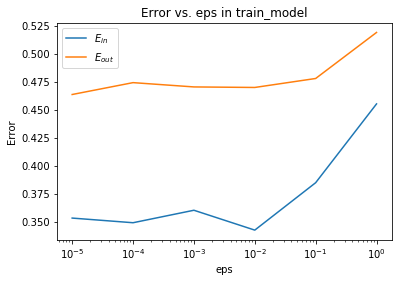

In [12]:
plt.plot(eps, E_in3, label='$E_{in}$')
plt.plot(eps, E_out3, label='$E_{out}$')
plt.xscale('log')
plt.title('Error vs. eps in train_model')
plt.xlabel('eps')
plt.ylabel('Error')
plt.legend()
plt.show()